# The price is right - Predictor


# Order of play

STEP 1: Data Curation  
STEP 2: Data Pre-processing  
STEP 3: Evaluation, Baselines, Traditional ML  
STEP 4: Deep Learning and LLMs  
STEP 5: Fine-tuning a Frontier Model  

## sTEP 1: Data Curation

We will use the below dataset from hugging face

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [2]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
from pricer.items import Item
from pricer.parser import parse
load_dotenv(override=True)

True

In [3]:
# Log in to HuggingFace 

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### Loading the Huggingface Dataset

In [4]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances", split="full", trust_remote_code=True)

README.md: 0.00B [00:00, ?B/s]

c:\Users\psiva\Documents\AI Projects\AI_LLM_Projects\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\psiva\.cache\huggingface\hub\datasets--McAuley-Lab--Amazon-Reviews-2023. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Amazon-Reviews-2023.py: 0.00B [00:00, ?B/s]

raw/meta_categories/meta_Appliances.json(…):   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [5]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


Test the dataset to check if any of them have price

In [6]:
# Investigation

#dataset[0]
#dataset[1]
#dataset[2]
#dataset[3]
dataset[6]



{'main_category': 'Appliances',
 'title': 'WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003',
 'average_rating': 4.6,
 'rating_number': 323,
 'features': ['【PARTS NUMBER】The WD12X10327 dishwasher top rack wheels and stud assembly Kit （4 pcs）',
  '【SCOPE OF APPLICATION】The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud',
  '【REPLACES PART】1811003, AP4980629, WD12X0330, WD12X0356, WD12X0357, WD12X0383, WD12X0385, WD12X10327, WD12X330, WD12X356, WD12X357, WD12X383, WD12X385',
  '【FIXES SYMPTOMS】Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure',
  '【QUALITY WARRANTY】The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask

In [7]:

# What's the most expensive item?

max_price = 0
max_item = None

for datapoint in tqdm(dataset):
    try:
        price = float(datapoint["price"])
        if price > max_price:
            max_item = datapoint
            max_price = price
    except ValueError:
        pass

print(f"The most expensive item is {max_item['title']} and it costs {max_price:,.2f}")

  0%|          | 0/94327 [00:00<?, ?it/s]

The most expensive item is TurboChef BULLET Rapid Cook Electric Microwave Convection Oven and it costs 21,095.62


In [8]:
max_item

{'main_category': 'Appliances',
 'title': 'TurboChef BULLET Rapid Cook Electric Microwave Convection Oven',
 'average_rating': 1.0,
 'rating_number': 1,
 'features': [],
 'description': [],
 'price': '21095.62',
 'images': {'hi_res': ['https://m.media-amazon.com/images/I/61oZOVndavL._AC_SL1000_.jpg'],
  'large': ['https://m.media-amazon.com/images/I/41rIxEeZKjL._AC_.jpg'],
  'thumb': ['https://m.media-amazon.com/images/I/41rIxEeZKjL._AC_SR38,50_.jpg'],
  'variant': ['MAIN']},
 'videos': {'title': [], 'url': [], 'user_id': []},
 'store': 'TurboChef',
 'categories': [],
 'details': '{"Brand Name": "TurboChef", "Energy Use": "800 Watts", "Installation Type": "Over-the-Range", "Special Features": "Timer", "Date First Available": "November 2, 2016"}',
 'parent_asin': 'B01D05UB8M',
 'bought_together': None,
 'subtitle': None,
 'author': None}

A utility package for parsing is added

In [9]:
# Load into Item objects if they have a price range $1-$1000 and enough details

items = [parse(datapoint, "Appliances") for datapoint in tqdm(dataset)]
items = [item for item in items if item is not None]
print(f"There are {len(items):,} items from {len(dataset):,} datapoints")

  0%|          | 0/94327 [00:00<?, ?it/s]

There are 35,307 items from 94,327 datapoints


In [10]:
items[0]

<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>

In [11]:
print(items[0].full)

Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces   1811003
['【PARTS NUMBER】The  dishwasher top rack wheels and stud assembly Kit （4 pcs）', '【SCOPE OF 】The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud', '【 PART】, , , , , , , , , , , , ', '【FIXES SYMPTOMS】Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure', '【QUALITY WARRANTY】The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask for a replacement or full refund']
{"Brand Name": "AMI PARTS", "Model Info": "", "Item Weight": "0.634 ounces", "Color": "White", "Material Type": "Plastic", "Date First Available": "July 14, 2019", "Brand": "AMI PARTS", "Material": "Plastic", "Model Name": " Rack Roller and stud 

In [12]:
prices = [item.price for item in items]
lengths = [len(item.full) for item in items]

### Plot for longest discription item

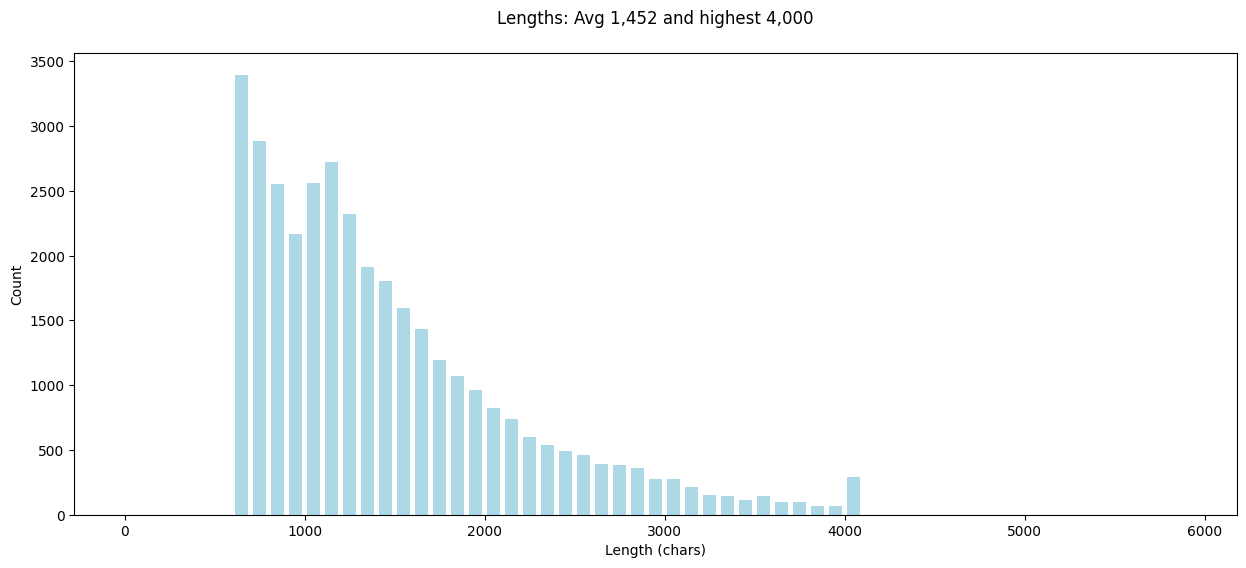

In [13]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

In [14]:
# Finding the item with the max length
max_length = max(lengths)
max_length_item = items[lengths.index(max_length)]
print(max_length_item.full)

Polyester Dryer Vent Filters Replacement Part by Beaquicy Replacement for Better vent Indoor Dryer Vent Packs of 12
['✅【 AIR 】--- The polyester filters provide optimal air conditioning for your dryer and keep it away from polluted air. Because these parts will rate to trap fine lint and dust particles, protect your home from unwanted bacteria and other unfriendly dust particles and can be vacuumed clean or replaced when fully loaded with lint. so that the air in your room is cleaner than ever. While protecting your indoor quality, clothes can dry faster. It helps improve the indoor air quality.', '✅【HIGH-GRADE 】--- The package includes 12 x replacement polyester filters for bettervent.They are well-made from durable and high-grade polyester which can traps fine lint and dust particles, optimize the cleaning process and prolong lifetime. Each filter protects up to 5 dryer loads! For best results insert blue side facing towards dryer vent.', '✅【WIDE 】--- These polyester filters are desig

### Plot for price distribution

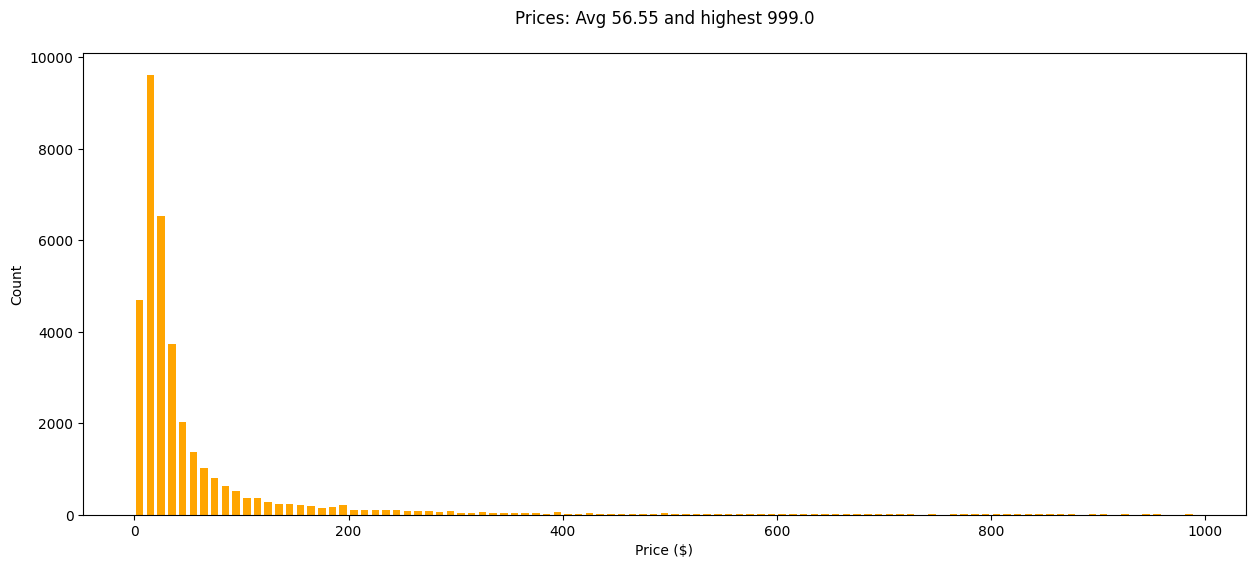

In [15]:
# Plot the distribution of prices
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [16]:
from pricer.loaders import ItemLoader
loader = ItemLoader("Appliances")
items = loader.load()

Loading dataset Appliances


100%|██████████| 95/95 [00:11<00:00,  8.39it/s]


Completed Appliances with 35,307 datapoints in 0.2 mins


In [ ]:
## All the categories in the dataset
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    # "Musical_Instruments",
]


I removed other from the list to save time on loading and parsing. but uncommet to run on all the categories

In [ ]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

### Data Cleaning for duplicates with title and duplicate as a whole

In [18]:
print(f"A grand total of {len(items):,} items")

A grand total of 35,307 items


In [19]:
random.seed(42)
random.shuffle(items)

seen = set()
items = [x for x in tqdm(items) if not (x.title in seen or seen.add(x.title))]

seen = set()
items = [x for x in tqdm(items) if not (x.full in seen or seen.add(x.full))]

del seen
print(f"After deduplication, we have {len(items):,} items")

  0%|          | 0/35307 [00:00<?, ?it/s]

  0%|          | 0/33634 [00:00<?, ?it/s]

After deduplication, we have 32,721 items


AS seen above some duplicates have been removed and cleaned

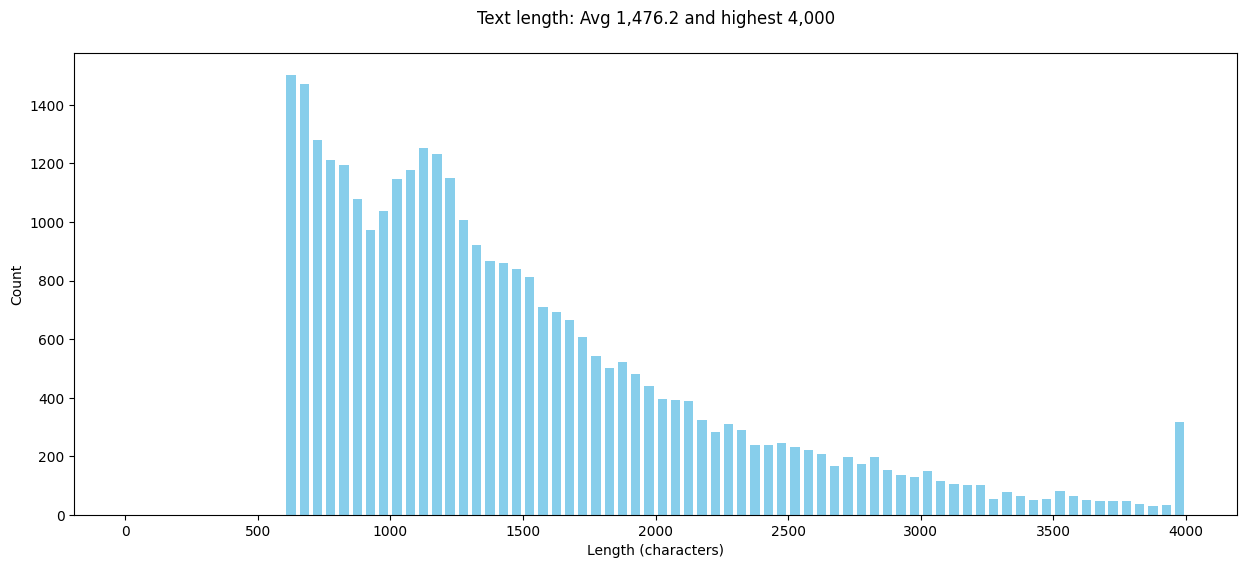

In [20]:
lengths = [len(item.full) for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Text length: Avg {sum(lengths)/len(lengths):,.1f} and highest {max(lengths):,}\n")
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="skyblue", bins=range(0, 4050, 50))
plt.show()

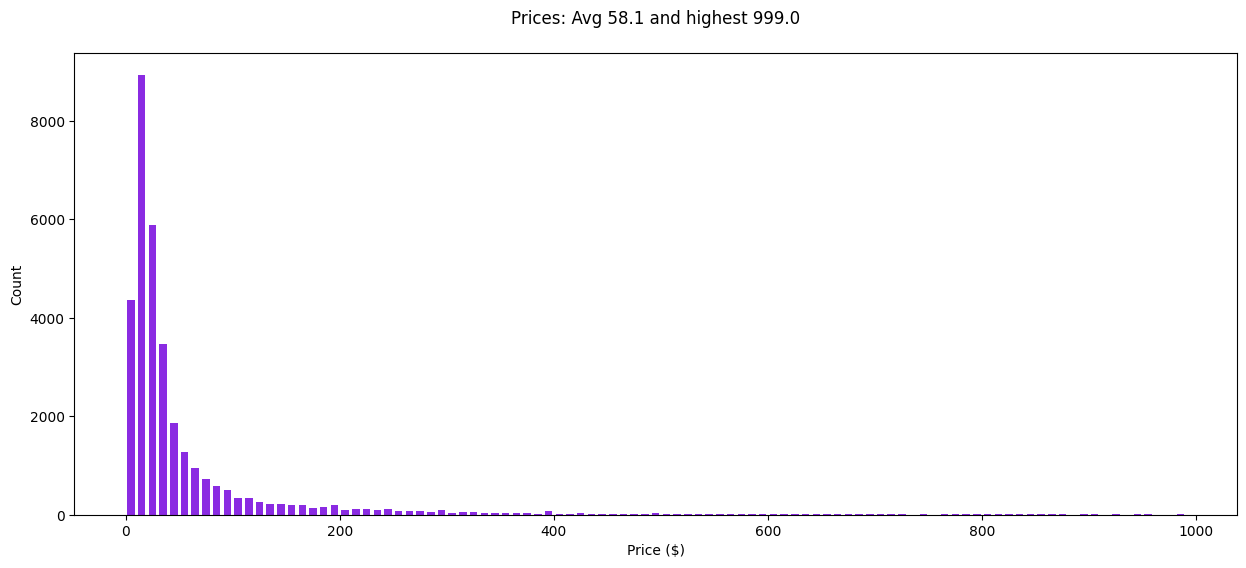

In [21]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

Note: As I have not included other categories i can see only one Bar

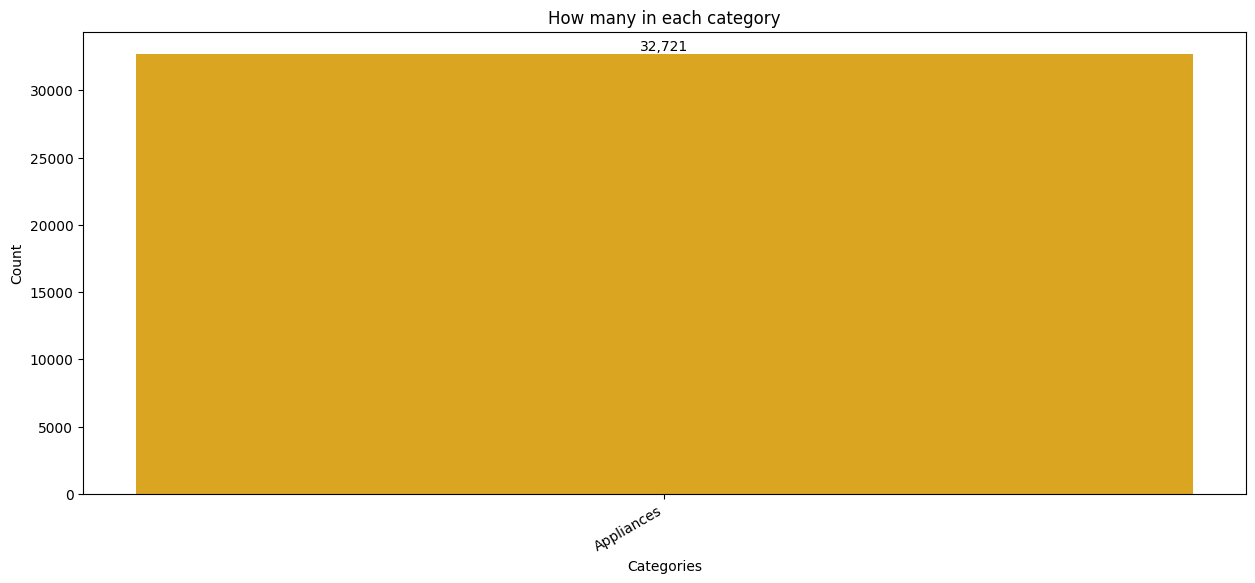

In [22]:
from collections import Counter
category_counts = Counter([item.category for item in items])

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

### weighted Sampling

Why this is done
1. Oversampling expensive items
p² gives higher probability to higher prices (e.g. p=0.8 → 0.64, p=0.2 → 0.04).
In many product datasets, cheap items dominate; uniform sampling would underrepresent high prices.
This helps the model see more expensive examples during training.
2. Undersampling Appliances
Appliances may dominate the dataset, so their weights are halved.
This balances the influence of categories and reduces overfitting to Appliances.
Overall intent
The goal is training set balance so the model:
Learns price prediction across the full price range (especially higher prices).
Does not overfit to the most common category (Appliances).

In [32]:
np.random.seed(42) ## Random selection

SIZE = 10_000

prices = np.array([it.price for it in items], dtype=float)
categories = np.array([it.category for it in items])
p = (prices - prices.min()) / (prices.max() - prices.min() + 1e-9) #Formula

w = p**2
w[categories == "Applicances"] *= 0.5 ## Numbpy way to change the weight (prices) based on category & price indexes
# w[categories == "Automotive"] *= 0.05

w = w / w.sum()
idx = np.random.choice(len(items), size=SIZE, replace=False, p=w)
sample = [items[i] for i in idx]


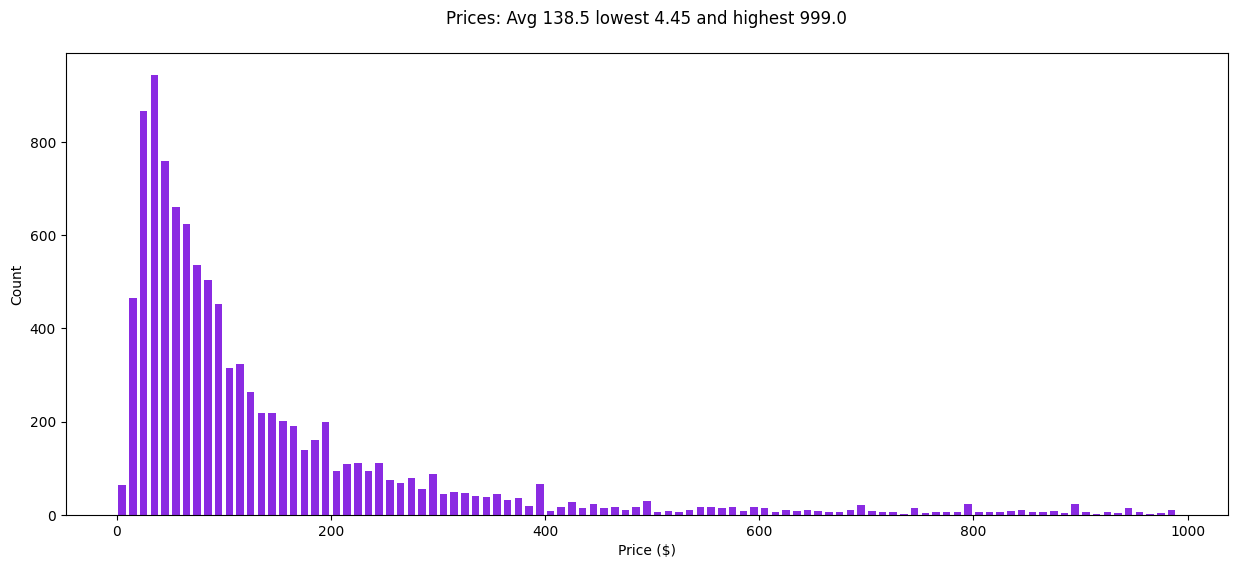

In [33]:
prices = [item.price for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} lowest {min(prices):,} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

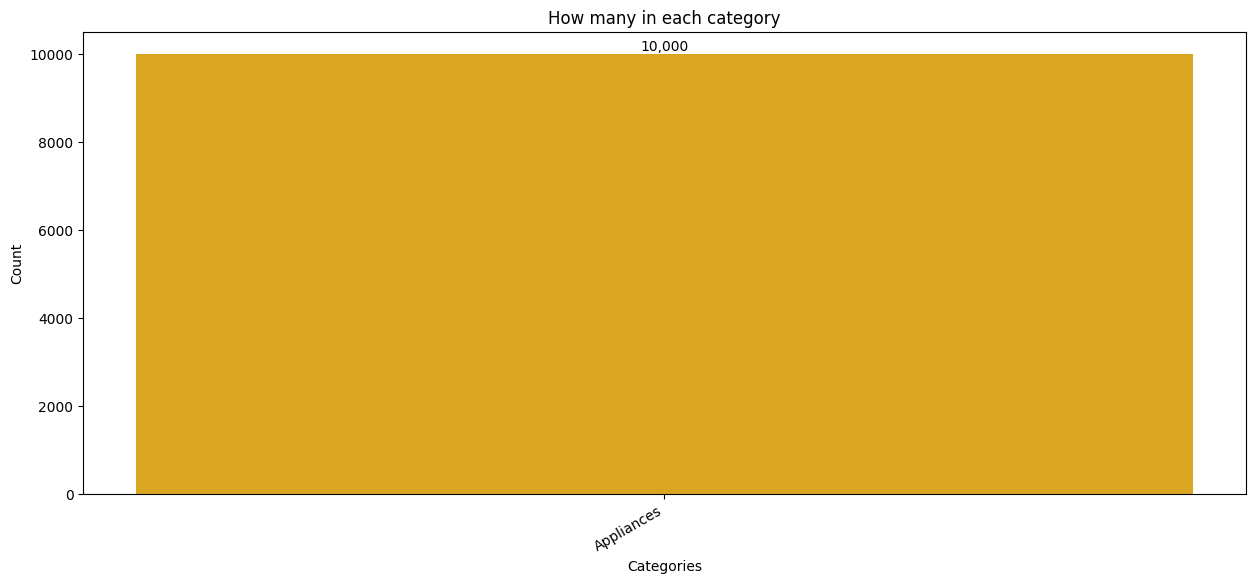

In [34]:
from collections import Counter
category_counts = Counter([item.category for item in sample])

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

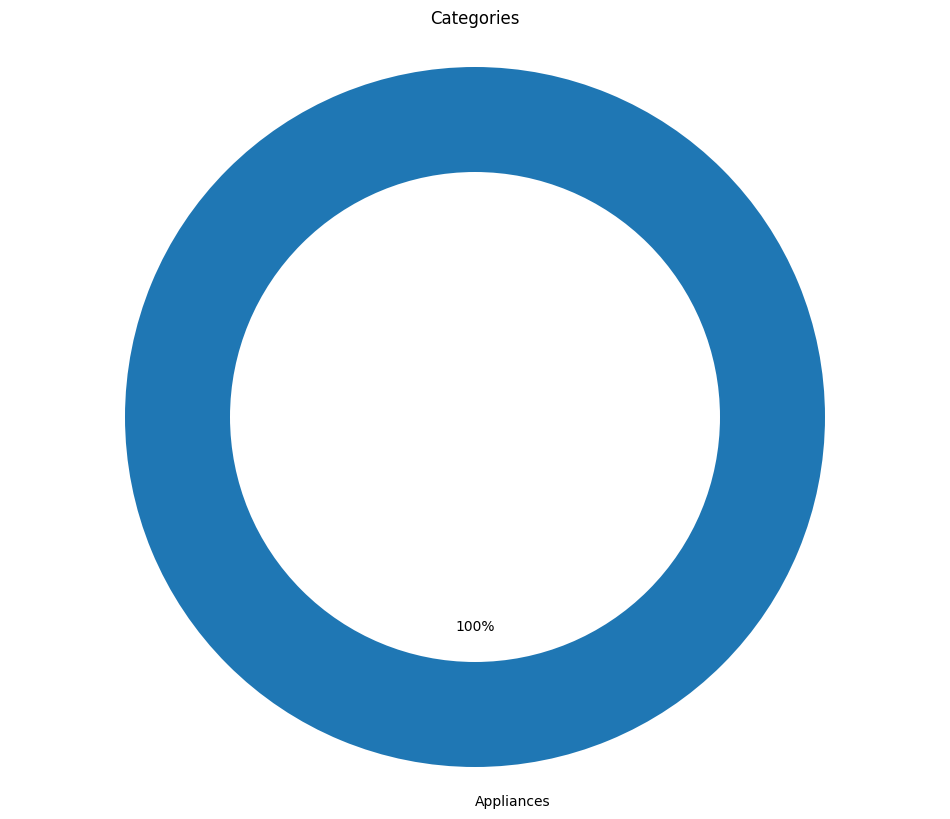

In [35]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

Finding Correlation

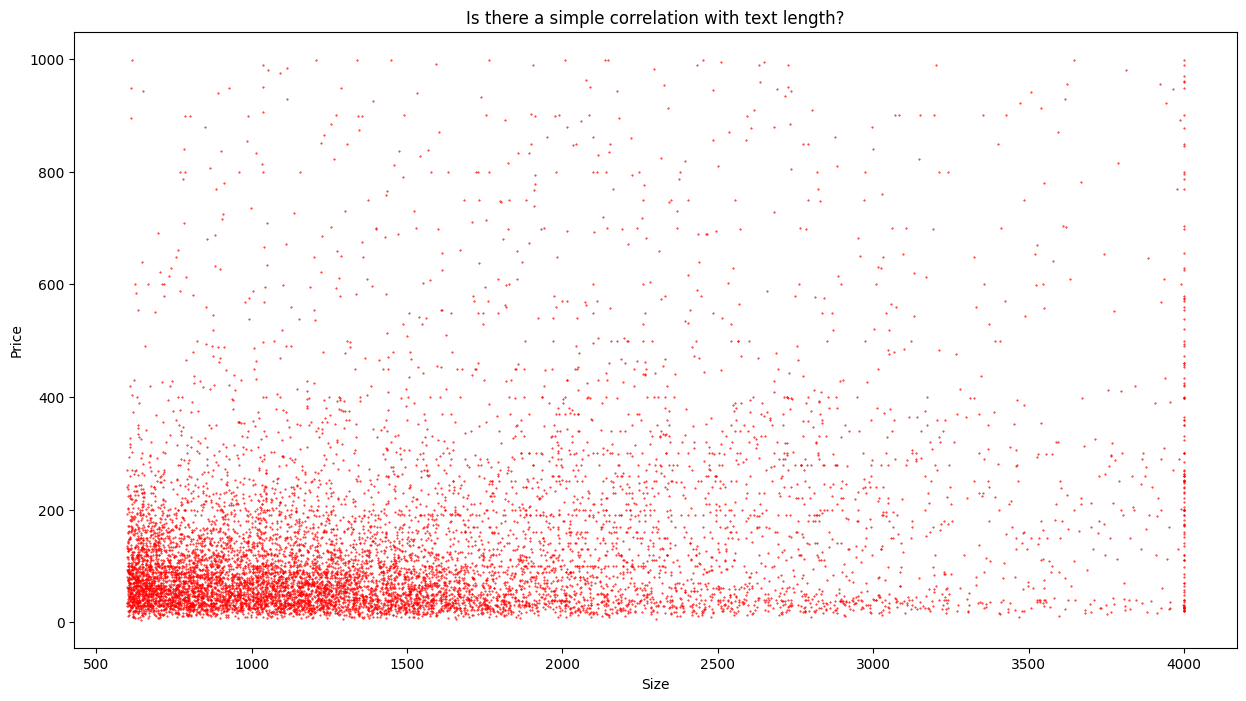

In [36]:
# How does the price vary with the character count?

sizes = [len(item.full) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation with text length?')

# Display the plot
plt.show()

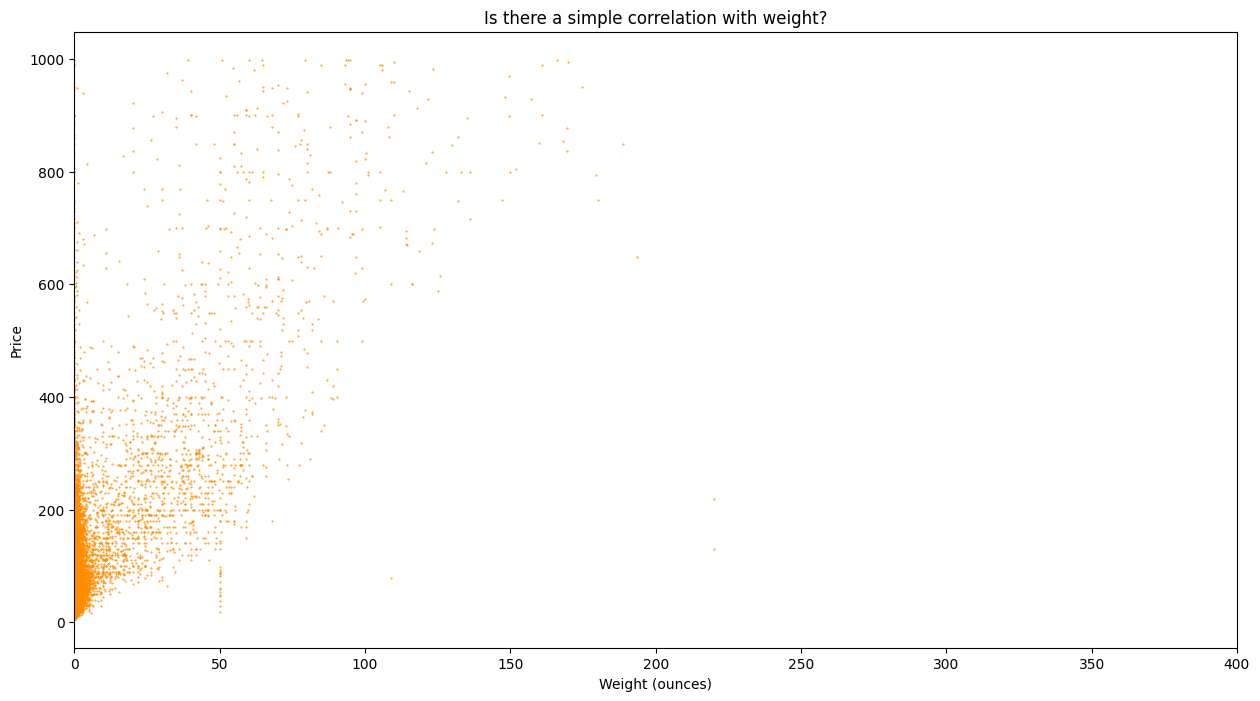

In [37]:
# How does the price vary with the weight?

ounces = [item.weight for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(ounces, prices, s=0.2, color="darkorange")

# Add labels and title
plt.xlabel('Weight (ounces)')
plt.ylabel('Price')
plt.xlim(0, 400)
plt.title('Is there a simple correlation with weight?')

# Display the plot
plt.show()

Code to push to the huggging face Dataset.

In [ ]:
username = "myusername"
full = f"{username}/items_raw_full"
lite = f"{username}/items_raw_lite"

train = sample[:10_000]
val = sample[10_000:10_500]
test = sample[10_500:]

Item.push_to_hub(full, train, val, test)

train_lite = train[:5_000]
val_lite = val[:1_000]
test_lite = test[:1_000]

Item.push_to_hub(lite, train_lite, val_lite, test_lite)

In [40]:
items[0].full

'2-Pack Replacement for Whirlpool  Refrigerator Water Filter - Compatible with Whirlpool  Fridge Water Filter Cartridge\n[\'This is a Denali Pure Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any OEM brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by Denali Pure.\']\n[\'Replacement for  Filter\']\n{"Manufacturer": "Denali Pure", "Is Discontinued By Manufacturer": "No", "Date First Available": "May 27, 2015"}'

# Step 2: Data Pre-processing  

In [41]:
from litellm import completion
from dotenv import load_dotenv
import json
from pricer.batch import Batch
from pricer.items import Item

load_dotenv(override=True)

True

In [ ]:
LITE_MODE = True

In [ ]:
username = "username"
dataset = f"{username}/items_raw_lite" if LITE_MODE else f"{username}/items_raw_full"

train, val, test = Item.from_hub(dataset)

items = train + val + test

print(f"Loaded {len(items):,} items")
print(items[0])

In [ ]:
# Give every item an id

for index, item in enumerate(items):
    item.id = index

In [47]:
SYSTEM_PROMPT = """Create a concise description of a product. Respond only in this format. Do not include part numbers.
Title: Rewritten short precise title
Category: eg Electronics
Brand: Brand name
Description: 1 sentence description
Details: 1 sentence on features"""

In [ ]:
messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": items[0].full}]
response = completion(messages=messages, model="groq/openai/gpt-oss-20b", reasoning_effort="low")

print(response.choices[0].message.content)
print()
print(f"Input tokens: {response.usage.prompt_tokens}")
print(f"Output tokens: {response.usage.completion_tokens}")
print(f"Cost: {response._hidden_params['response_cost']*100:.3f} cents")

In [ ]:

messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": items[0].full}]
response = completion(messages=messages, model="ollama/llama3.2", api_base="http://localhost:11434")
print(response.choices[0].message.content)
print()
print(f"Input tokens: {response.usage.prompt_tokens}")
print(f"Output tokens: {response.usage.completion_tokens}")
print(f"Cost: {response._hidden_params['response_cost']*100:.3f} cents")

In [45]:
MODEL = "openai/gpt-oss-20b"

## LLM Batch Processing. Many LLMS provide a way to make batch requests that is also cheap.

The below code helps to make a batch request object with the prompt and data to be passed in a jsonl dump file that will be read by the batch processor in the pricer code to send request to the api and save the results. 

In [42]:
def make_jsonl(item):
    body = {"model": MODEL, "messages": [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": item.full}], "reasoning_effort": "low"}
    line = {"custom_id": str(item.id), "method": "POST", "url": "/v1/chat/completions", "body": body}
    return json.dumps(line)

In [43]:
items[0]

<2-Pack Replacement for Whirlpool GI5FSAXVY00 Refrigerator Water Filter - Compatible with Whirlpool 4396395 Fridge Water Filter Cartridge = $21.99>

In [48]:
make_jsonl(items[0])

'{"custom_id": "None", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "openai/gpt-oss-20b", "messages": [{"role": "system", "content": "Create a concise description of a product. Respond only in this format. Do not include part numbers.\\nTitle: Rewritten short precise title\\nCategory: eg Electronics\\nBrand: Brand name\\nDescription: 1 sentence description\\nDetails: 1 sentence on features"}, {"role": "user", "content": "2-Pack Replacement for Whirlpool  Refrigerator Water Filter - Compatible with Whirlpool  Fridge Water Filter Cartridge\\n[\'This is a Denali Pure Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any OEM brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by De

In [53]:

def make_file(start, end, filename):
    batch_file = filename
    with open(batch_file, "w") as f:
        for i in range(start, end):
            f.write(make_jsonl(items[i]))
            f.write("\n")

In [54]:
make_file(0, 1000, "jsonl/0_1000.jsonl")

Groq has a best batch processing mode that uses gpt oss model with fast inference, we can use any batch supported llms

In [55]:
import os
from groq import Groq

groq = Groq(api_key=os.environ.get("GROQ_API_KEY"))

with open("jsonl/0_1000.jsonl", "rb") as f:
    response = groq.files.create(file=f, purpose="batch")

file_id = response.id

# Async Batch call
response = groq.batches.create(completion_window="24h", endpoint="/v1/chat/completions", input_file_id=file_id)

result = groq.batches.retrieve(response.id) # Result will show Completed status after sometime

# loading the result from cloud output store
response = groq.files.content(result.output_file_id)

# write the result to local
response.write_to_file("jsonl/batch_results.jsonl")

# Parse the result
with open("jsonl/batch_results.jsonl", "r") as f:
    for line in f:
        json_line = json.loads(line)
        id = int(json_line["custom_id"])
        summary = json_line["response"]["body"]["choices"][0]["message"]["content"]
        items[id].summary = summary

# New summary field with the better optimal version of the Item[0].full
print(items[1000].summary);



SyntaxError: incomplete input (56493302.py, line 4)

##Batch class - Batch preProcessing

- Divides items into groups of 1,000
- Kicks off batches for each
- Allows us to monitor and collect the results when complete

In [ ]:
Batch.create(items, LITE_MODE)

In [ ]:
Batch.run()

In [ ]:
Batch.fetch()

In [ ]:
for index, item in enumerate(items):
    if not item.summary:
        print(index)

In [ ]:
# Remove the fields that we don't need in the hub to [push] to cloud in huggingface dataset

for item in items:
    item.full = None
    item.id = None

In [ ]:
username = "<username>"
full = f"{username}/items_full"
lite = f"{username}/items_lite"

if LITE_MODE:
    train = items[:20_000]
    val = items[20_000:21_000]
    test = items[21_000:]
    Item.push_to_hub(lite, train, val, test)
else:
    train = items[:800_000]
    val = items[800_000:810_000]
    test = items[810_000:]
    Item.push_to_hub(full, train, val, test)

    train_lite = train[:20_000]
    val_lite = val[:1_000]
    test_lite = test[:1_000]
    Item.push_to_hub(lite, train_lite, val_lite, test_lite)

## STEP 3: Evaluation, Baselines, Traditional ML

- simple models to predict the price of a product

- approach to evaluate the performance of the model

- test some Baseline Models using Traditional machine learning

In [56]:
import random
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from pricer.evaluator import evaluate
from pricer.items import Item

In [57]:
LITE_MODE = True

In [67]:
username = "<username>"
dataset = f"{username}/items_lite" if LITE_MODE else f"{username}/items_full"

train, val, test = Item.from_hub(dataset)

print(f"Loaded {len(train):,} training items, {len(val):,} validation items, {len(test):,} test items")

Loaded 20,000 training items, 1,000 validation items, 1,000 test items


In [68]:
def random_pricer(item):
    return random.randrange(1,1000)

In [69]:
random.seed(42)
evaluate(random_pricer, test)

  0%|          | 0/200 [00:00<?, ?it/s]

$436 $1 $29 $690 $252 $21 $85 $72 $719 $225 $20 $380 $894 $505 $11 $572 $354 $17 $179 $23 $90 $115 $433 $442 $304 $122 $291 $714 $567 $639 $539 $370 $66 $380 $489 $534 $769 $835 $207 $740 $626 $84 $680 $178 $129 $260 $142 $189 $836 $580 $310 $25 $380 $270 $47 $234 $861 $313 $417 $259 $591 $33 $657 $361 $79 $38 $757 $500 $263 $5 $534 $284 $570 $625 $584 $871 $759 $361 $575 $178 $602 $60 $17 $579 $207 $732 $115 $224 $756 $193 $866 $9 $370 $250 $456 $423 $821 $217 $103 $195 $264 $98 $650 $135 $470 $842 $675 $264 $43 $325 $591 $138 $516 $619 $56 $2 $449 $369 $221 $845 $640 $616 $501 $59 $502 $273 $844 $688 $616 $81 $164 $705 $52 $795 $259 $396 $70 $2 $89 $798 $902 $331 $818 $716 $129 $186 $627 $2 $141 $873 $918 $553 $423 $7 $253 $136 $204 $707 $255 $502 $19 $739 $557 $426 $80 $575 $39 $321 $185 $132 $497 $484 $326 $751 $53 $733 $85 $64 $549 $71 $158 $672 $133 $362 $16 $373 $258 $544 $420 $515 $223 $944 $532 $743 $866 $68 $527 $459 $67 $673 

The above Random Pricer simple gives a random price which the evaluator will take as the predictor function and makes a comparison with the test data and the train data.

In [70]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)
print(training_average)

def constant_pricer(item):
    return training_average

evaluate(constant_pricer, test)

140.347293


  0%|          | 0/200 [00:00<?, ?it/s]

$79 $24 $85 $70 $110 $90 $4 $75 $105 $190 $573 $239 $120 $86 $61 $107 $61 $90 $70 $21 $6 $16 $55 $35 $192 $312 $355 $120 $42 $60 $120 $80 $20 $60 $25 $679 $81 $84 $73 $102 $59 $60 $105 $115 $80 $115 $122 $109 $5 $62 $105 $10 $335 $21 $87 $6 $133 $100 $62 $128 $96 $62 $49 $30 $488 $50 $100 $305 $15 $64 $109 $123 $140 $121 $90 $104 $16 $130 $123 $122 $20 $128 $110 $41 $113 $80 $42 $166 $20 $95 $118 $45 $120 $105 $132 $88 $106 $17 $130 $435 $40 $23 $103 $1 $109 $22 $115 $260 $109 $159 $80 $174 $109 $12 $55 $30 $116 $120 $84 $37 $124 $51 $70 $26 $60 $80 $120 $41 $39 $1 $69 $3 $55 $110 $75 $125 $65 $70 $12 $2 $76 $110 $60 $121 $54 $108 $95 $370 $125 $107 $121 $34 $93 $0 $121 $139 $91 $84 $179 $90 $149 $114 $98 $127 $700 $117 $307 $90 $100 $130 $115 $118 $280 $118 $39 $9 $112 $47 $46 $47 $514 $115 $160 $108 $90 $118 $7 $73 $80 $114 $105 $89 $105 $2 $40 $60 $30 $140 $89 $114 

In [71]:
def get_features(item):
    return {
        "weight": item.weight,
        "weight_unknown": 1 if item.weight==0 else 0,
        "text_length": len(item.summary)
    }

In [72]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test)

In [73]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'weight_unknown', 'text_length']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 3.5687444142553044
weight_unknown: 20.90175988023751
text_length: 0.20343123739152702
Intercept: 40.91238780791184
Mean Squared Error: 20096.925335647466
R-squared Score: 0.1609102308229894


In [74]:
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

In [75]:
evaluate(linear_regression_pricer, test)

  0%|          | 0/200 [00:00<?, ?it/s]

$79 $51 $62 $66 $71 $50 $9 $50 $82 $191 $574 $233 $113 $58 $28 $97 $50 $62 $39 $14 $18 $14 $75 $11 $193 $318 $359 $91 $35 $36 $104 $78 $27 $16 $79 $676 $65 $66 $70 $67 $64 $36 $61 $66 $104 $93 $104 $83 $25 $60 $84 $5 $347 $2 $79 $20 $110 $83 $23 $123 $111 $49 $19 $3 $241 $17 $82 $261 $6 $68 $85 $105 $155 $89 $91 $80 $3 $98 $99 $88 $72 $86 $86 $8 $84 $43 $81 $176 $62 $60 $88 $42 $80 $71 $91 $117 $78 $8 $146 $418 $33 $7 $106 $21 $122 $1 $83 $298 $104 $198 $62 $154 $106 $59 $71 $53 $103 $94 $82 $14 $99 $43 $51 $51 $127 $47 $86 $102 $72 $16 $53 $9 $47 $72 $45 $84 $81 $40 $9 $11 $39 $132 $55 $85 $3 $71 $71 $364 $5 $72 $93 $26 $53 $21 $90 $119 $103 $40 $43 $79 $160 $92 $67 $116 $725 $100 $279 $74 $84 $101 $86 $100 $244 $78 $139 $58 $95 $7 $50 $38 $289 $117 $38 $94 $75 $96 $6 $77 $57 $79 $79 $78 $108 $21 $14 $97 $50 $109 $90 $114 

## Note

As we can see above the model predictions is not that great. The reason for this is the feature selection. For tranditional ML we need to pick the correct features based on which the target data is dependent on ie. Y depends on set of X. Here we selected weight of the product and description.


Linear regression works purely based on numbers and predictions based on vector calculations. So feature selection is really important. for example predicting the weight of a person based on height and body factors like muscle mass, bla bla as an example.

In [79]:
prices = np.array([float(item.price) for item in train])
documents = [item.summary for item in train]

### Creating a bag of words for the feature extractions of vocabulary

In [ ]:
np.random.seed(42)
# Bag of words - Vocabulary of 2000
vectorizer = CountVectorizer(max_features=2000, stop_words='english') # This is a feature extractor package function that helps to identify feature eligible words
X = vectorizer.fit_transform(documents)

In [83]:
# Here are the 1,000 most common words that it picked, not including "stop words": like and to a the

selected_words = vectorizer.get_feature_names_out()
print(f"Number of selected words: {len(selected_words)}")
print("Selected words:", selected_words[1000:1020])

Number of selected words: 2000
Selected words: ['items' 'jack' 'jacket' 'jeep' 'jigsaw' 'joint' 'joints' 'keeping'
 'keeps' 'key' 'keyboard' 'keypad' 'keys' 'kg' 'khz' 'kia' 'kickstand'
 'kids' 'king' 'kingston']


In [85]:
regressor = LinearRegression()
regressor.fit(X, prices)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [86]:
def natural_language_linear_regression_pricer(item):
    x = vectorizer.transform([item.summary]) # This will map all the features in 2000 with 1 and 0
    return max(regressor.predict(x)[0], 0)

In [87]:
evaluate(natural_language_linear_regression_pricer, test)

  0%|          | 0/200 [00:00<?, ?it/s]

$86 $120 $55 $70 $191 $230 $24 $41 $8 $65 $480 $188 $61 $132 $19 $139 $64 $31 $25 $27 $39 $86 $51 $20 $318 $360 $149 $36 $38 $32 $75 $58 $3 $26 $120 $338 $10 $106 $142 $73 $151 $110 $88 $9 $89 $42 $74 $72 $14 $35 $41 $49 $154 $42 $78 $167 $111 $194 $15 $12 $40 $3 $55 $21 $426 $35 $26 $191 $11 $224 $24 $46 $92 $111 $19 $49 $140 $11 $20 $125 $7 $37 $71 $43 $60 $103 $5 $149 $52 $255 $30 $142 $84 $41 $52 $133 $64 $56 $213 $108 $88 $57 $37 $35 $3 $51 $14 $162 $31 $71 $15 $79 $206 $13 $33 $123 $119 $31 $49 $19 $16 $159 $8 $27 $65 $24 $20 $45 $58 $59 $5 $63 $181 $14 $26 $47 $1 $151 $99 $104 $49 $141 $5 $203 $139 $74 $19 $317 $19 $22 $19 $263 $30 $37 $43 $56 $163 $16 $102 $13 $63 $26 $42 $13 $387 $9 $85 $50 $2 $10 $10 $61 $318 $65 $69 $82 $8 $74 $0 $120 $386 $11 $58 $21 $107 $39 $5 $67 $150 $27 $38 $52 $33 $36 $32 $59 $45 $28 $15 $36 

In [88]:
subset = 15_000
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
rf_model.fit(X[:subset], prices[:subset])

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

## Random Forest model

The Random Forest is a type of "**ensemble**" algorithm, meaning that it combines many smaller algorithms to make better predictions.

It uses a very simple kind of machine learning algorithm called a **decision tree**. A decision tree makes predictions by examining the values of features in the input. Like a flow chart with IF statements. Decision trees are very quick and simple, but they tend to overfit.

In our case, the "features" are the elements of the Vector - in other words, it's the number of times that a particular word appears in the product description.

So you can think of it something like this:

**Decision Tree**  
\- IF the word "TV" appears more than 3 times THEN  
-- IF the word "LED" appears more than 2 times THEN  
--- IF the word "HD" appears at least once THEN  
---- Price = $500


With Random Forest, multiple decision trees are created. Each one is trained with a different random subset of the data, and a different random subset of the features. You can see above that we specify 100 trees, which is the default.

Then the Random Forest model simply takes the average of all its trees to product the final result.

In [89]:
def random_forest(item):
    x = vectorizer.transform([item.summary])
    return max(0, rf_model.predict(x)[0])

In [90]:
evaluate(random_forest, test)

  0%|          | 0/200 [00:00<?, ?it/s]

$67 $67 $8 $10 $112 $139 $74 $56 $27 $266 $517 $288 $40 $76 $11 $17 $50 $106 $33 $50 $22 $9 $9 $30 $148 $316 $161 $124 $30 $49 $54 $80 $86 $17 $21 $367 $48 $28 $145 $82 $150 $42 $18 $42 $146 $28 $48 $40 $59 $11 $11 $29 $236 $29 $314 $41 $36 $157 $7 $47 $107 $4 $61 $6 $460 $3 $14 $179 $28 $129 $12 $24 $69 $128 $4 $97 $107 $17 $33 $73 $60 $70 $23 $48 $14 $31 $14 $101 $5 $101 $33 $164 $1 $82 $57 $64 $2 $47 $138 $274 $44 $6 $10 $78 $34 $29 $116 $205 $20 $176 $37 $68 $63 $29 $69 $22 $76 $11 $216 $25 $27 $40 $60 $37 $40 $28 $43 $46 $105 $2 $24 $48 $68 $17 $37 $53 $30 $11 $75 $32 $12 $151 $4 $103 $106 $66 $36 $325 $79 $4 $21 $99 $48 $75 $57 $80 $112 $39 $35 $10 $6 $4 $3 $27 $400 $46 $271 $31 $6 $35 $21 $6 $213 $25 $9 $65 $47 $5 $42 $4 $341 $16 $83 $87 $161 $57 $50 $83 $2 $39 $51 $52 $25 $17 $6 $21 $68 $36 $5 $17 

In [91]:
# This is how to save the model if you want to, particularly if you run this on a larger dataset

import joblib
joblib.dump(rf_model, "random_forest.joblib")

['random_forest.joblib']

## Introducing XGBoost

Like Random Forest, XGBoost is also an ensemble model that combines multiple decision trees.

But unlike Random Forest, XGBoost builds one tree after another, with each next tree correcting for errors in the prior trees, using 'gradient descent'.

It's much faster than Random Forest, so we can run it for the full dataset, and it's typically better at generalizing.

**If this import doesn't work, please skip this! It's not required. On a Mac, you might need to do `brew install libomp` in the terminal.**

In [92]:
import xgboost as xgb

In [95]:
np.random.seed(42)

xgb_model = xgb.XGBRegressor(n_estimators=1000, random_state=42, n_jobs=4, learning_rate=0.1)
xgb_model.fit(X, prices)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [ ]:
def xg_boost(item):
    x = vectorizer.transform([item.summary])
    return max(0, xgb_model.predict(x)[0]) ## Here we are predicting for single value

In [96]:
evaluate(xg_boost, test)

  0%|          | 0/200 [00:00<?, ?it/s]

$82 $81 $30 $16 $107 $160 $39 $3 $16 $21 $601 $245 $107 $107 $0 $17 $55 $13 $15 $15 $11 $25 $5 $68 $234 $321 $95 $31 $40 $28 $84 $55 $9 $9 $54 $124 $24 $69 $164 $68 $154 $88 $63 $8 $118 $113 $37 $57 $43 $8 $30 $37 $126 $8 $236 $95 $61 $193 $2 $41 $72 $8 $71 $35 $444 $33 $46 $208 $50 $100 $2 $43 $92 $106 $13 $200 $222 $10 $34 $117 $22 $95 $87 $40 $19 $50 $63 $124 $26 $226 $34 $196 $27 $3 $25 $93 $124 $26 $199 $168 $114 $40 $23 $61 $5 $91 $175 $207 $31 $66 $39 $64 $72 $54 $79 $140 $129 $29 $136 $42 $45 $98 $35 $33 $135 $4 $16 $97 $179 $99 $38 $52 $141 $35 $9 $70 $74 $48 $164 $93 $2 $148 $55 $89 $82 $96 $36 $260 $11 $5 $19 $163 $46 $60 $25 $96 $117 $16 $21 $4 $74 $21 $8 $13 $397 $2 $147 $50 $15 $11 $22 $26 $209 $32 $31 $47 $50 $32 $37 $58 $423 $12 $137 $30 $113 $59 $61 $45 $65 $30 $47 $20 $16 $17 $4 $71 $57 $41 $40 $26 

### Final Evaluation SCores

In [98]:
import plotly.graph_objects as go
results = [
    ("Constant", "gray", 106.18),
    ("Linear Regression", "gray", 101.56),
    ("NLP + LR", "gray", 76.81),
    ("Random Forest", "gray", 72.28),
    ("XGBoost", "gray", 68.23),
    ("Human (Ed)", "black", 87.62),
    ("Neural Network", "orange", 63.97),
    ("GPT 4.1 Nano", "slateblue", 62.51),
    ("Grok 4.1 Fast", "slateblue", 57.62),
    ("Gemini 3 Pro", "slateblue", 50.54),
    ("Claude 4.5 Sonnet", "slateblue", 47.10),
    ("GPT 5.1", "green", 44.74),
    ("GPT 4.1 Nano (Fine-tuned)", "red", 75.91),
    ("Deep Neural Network", "orange", 46.49)
]

labels, colors, values = zip(*results)

fig = go.Figure(go.Bar(x=labels, y=values, marker_color=colors))

fig.update_layout(
    title="Week 6 model improvements - see the videos to reveal which triumphs!",
    yaxis=dict(range=[0, max(values)], title="Error"),
    xaxis=dict(tickangle=-45),
    width=1000,
    height=800
)

fig.show()